In [1]:
##############################################################
# % Author: Castle
# % Date:14/01/2023
###############################################################
import argparse
import os
import numpy as np
import cv2
import sys
# BASE_DIR = os.path.dirname(os.path.abspath(__file__))
# sys.path.append(os.path.join(BASE_DIR, '../'))
BASE_DIR = '.'

from tools import builder
from utils.config import cfg_from_yaml_file
from utils import misc
from datasets.io import IO
from datasets.data_transforms import Compose


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        'model_config', 
        help = 'yaml config file')
    parser.add_argument(
        'model_checkpoint', 
        help = 'pretrained weight')
    parser.add_argument('--pc_root', type=str, default='', help='Pc root')
    parser.add_argument('--pc', type=str, default='', help='Pc file')   
    parser.add_argument(
        '--save_vis_img',
        action='store_true',
        default=False,
        help='whether to save img of complete point cloud') 
    parser.add_argument(
        '--out_pc_root',
        type=str,
        default='',
        help='root of the output pc file. '
        'Default not saving the visualization images.')
    parser.add_argument(
        '--device', default='cuda:0', help='Device used for inference')
    args = parser.parse_args()

    assert args.save_vis_img or (args.out_pc_root != '')
    assert args.model_config is not None
    assert args.model_checkpoint is not None
    assert (args.pc != '') or (args.pc_root != '')

    return args

def inference_single(model, pc_path, args, config, root=None):
    if root is not None:
        pc_file = os.path.join(root, pc_path)
    else:
        pc_file = pc_path
    # read single point cloud
    pc_ndarray = IO.get(pc_file).astype(np.float32)
    # transform it according to the model 
    if config.dataset.train._base_['NAME'] == 'ShapeNet':
        # normalize it to fit the model on ShapeNet-55/34
        centroid = np.mean(pc_ndarray, axis=0)
        pc_ndarray = pc_ndarray - centroid
        m = np.max(np.sqrt(np.sum(pc_ndarray**2, axis=1)))
        pc_ndarray = pc_ndarray / m

    transform = Compose([{
        'callback': 'UpSamplePoints',
        'parameters': {
            'n_points': 2048
        },
        'objects': ['input']
    }, {
        'callback': 'ToTensor',
        'objects': ['input']
    }])
    
    pc_ndarray_normalized = transform({'input': pc_ndarray})
    # inference
    ret = model(pc_ndarray_normalized['input'].unsqueeze(0).to(args.device.lower()))
    dense_points = ret[-1].squeeze(0).detach().cpu().numpy()

    if config.dataset.train._base_['NAME'] == 'ShapeNet':
        # denormalize it to adapt for the original input
        dense_points = dense_points * m
        dense_points = dense_points + centroid

    if args.out_pc_root != '':
        target_path = os.path.join(args.out_pc_root, os.path.splitext(pc_path)[0])
        os.makedirs(target_path, exist_ok=True)

        np.save(os.path.join(target_path, 'fine.npy'), dense_points)
        if args.save_vis_img:
            input_img = misc.get_ptcloud_img(pc_ndarray_normalized['input'].numpy())
            dense_img = misc.get_ptcloud_img(dense_points)
            cv2.imwrite(os.path.join(target_path, 'input.jpg'), input_img)
            cv2.imwrite(os.path.join(target_path, 'fine.jpg'), dense_img)
    
    return

def main():
    args = get_args()

    # init config
    config = cfg_from_yaml_file(args.model_config)
    # build model
    base_model = builder.model_builder(config.model)
    builder.load_model(base_model, args.model_checkpoint)
    base_model.to(args.device.lower())
    base_model.eval()

    if args.pc_root != '':
        pc_file_list = os.listdir(args.pc_root)
        for pc_file in pc_file_list:
            inference_single(base_model, pc_file, args, config, root=args.pc_root)
    else:
        inference_single(base_model, args.pc, args, config)

# if __name__ == '__main__':
#     main()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
import gdown

gdown.download(
    "https://drive.google.com/u/0/uc?id=182xUHiUyIQhgqstFTVPoCyYyxmdiZlxq",
    fuzzy=True,
)
# gdown.download(
#     "https://drive.google.com/u/0/uc?id=1oPwXplvn9mR0dI9V7Xjw4RhGwrnBU4dg",
#     fuzzy=True,
# )
# gdown.download(
#     "https://drive.google.com/u/0/uc?id=17pE2U2T2k4w1KfmDbL6U-GkEwD-duTaF",
#     fuzzy=True,
# )

Downloading...
From (uriginal): https://drive.google.com/uc?id=182xUHiUyIQhgqstFTVPoCyYyxmdiZlxq
From (redirected): https://drive.google.com/uc?id=182xUHiUyIQhgqstFTVPoCyYyxmdiZlxq&confirm=t&uuid=81cd0a7e-e023-463b-8af8-a84d82da2f10
To: /root/PoinTr-API/PCN_Pretrained.pth
100%|██████████| 681M/681M [00:14<00:00, 48.0MB/s] 


'PCN_Pretrained.pth'

In [39]:
import argparse
# !python tools/inference.py \
#     cfgs/ShapeNet55_models/PoinTr.yaml pointr_training_from_scratch_c55_best.pth \
#     --pc demo/airplane.pcd \
#     --save_vis_img \
#     --out_pc_root inference_result

args = argparse.Namespace(
    model_config="cfgs/ShapeNet55_models/PoinTr.yaml",
    model_checkpoint="pointr_training_from_scratch_c55_best.pth",

    # model_config="cfgs/PCN_models/AdaPoinTr.yaml",
    # model_checkpoint="AdaPoinTr_PCN.pth",

    # model_config="cfgs/KITTI_models/PoinTr.yaml",
    # model_checkpoint="KITTI.pth",

    # model_config="cfgs/PCN_models/PoinTr.yaml",
    # model_checkpoint="PCN_Pretrained.pth",


    pc="demo/model.ply",
    # pc="demo/airplane.pcd",
    # pc_root="demo",
    save_vis_img=True,
    out_pc_root="inference_result",
    device='cuda:0'
)
# args = argparse
# args = get_args()

# # init config
config = cfg_from_yaml_file(args.model_config)
# # build model
base_model = builder.model_builder(config.model)
builder.load_model(base_model, args.model_checkpoint)
base_model.to(args.device.lower())
base_model.eval();

# if args.pc_root != '':
#     pc_file_list = os.listdir(args.pc_root)
#     for pc_file in pc_file_list:
#         inference_single(base_model, pc_file, args, config, root=args.pc_root)
# else:
#     inference_single(base_model, args.pc, args, config)

2023-04-04 11:32:57,747 - MODEL - INFO -  Transformer with knn_layer 1


Loading weights from pointr_training_from_scratch_c55_best.pth...
ckpts @ 104 epoch( performance = No Metrics)


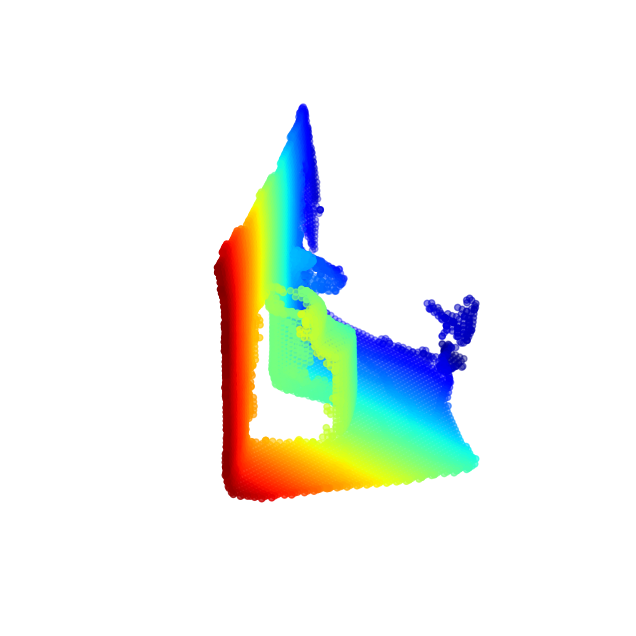

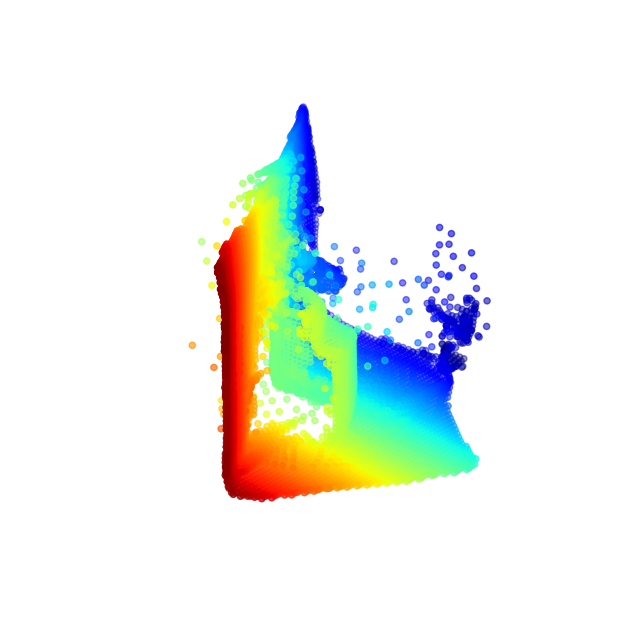

In [40]:
# inference_single(base_model, args.pc, args, config)
# def inference_single(model, pc_path, args, config, root=None):
model = base_model
pc_path = args.pc
args = args
config = config
root = None


#     pc_file_list = os.listdir(args.pc_root)
#     for pc_file in pc_file_list:
#         inference_single(base_model, pc_file, args, config, root=args.pc_root)
if root is not None:
    pc_file = os.path.join(root, pc_path)
else:
    pc_file = pc_path
# read single point cloud
pc_ndarray = IO.get(pc_file).astype(np.float32)
# transform it according to the model 

if config.dataset.train._base_['NAME'] == 'ShapeNet':
    # normalize it to fit the model on ShapeNet-55/34
    centroid = np.mean(pc_ndarray, axis=0)
    pc_ndarray = pc_ndarray - centroid
    m = np.max(np.sqrt(np.sum(pc_ndarray**2, axis=1)))
    pc_ndarray = pc_ndarray / m

transform = Compose([
    # {
    #     'callback': 'UpSamplePoints',
    #     'parameters': {
    #         # 'n_points': 2048
    #         'n_points': pc_ndarray.shape[0]
    #     },
    #     'objects': ['input']
    # }, 
    {
        'callback': 'ToTensor',
        'objects': ['input']
    }])
pc_ndarray_normalized = transform({'input': pc_ndarray})
# inference
ret = model(pc_ndarray_normalized['input'].unsqueeze(0).to(args.device.lower()))
dense_points = ret[-1].squeeze(0).detach().cpu().numpy()

if config.dataset.train._base_['NAME'] == 'ShapeNet':
    # denormalize it to adapt for the original input
    dense_points = dense_points * m
    dense_points = dense_points + centroid

if args.out_pc_root != '':
    target_path = os.path.join(args.out_pc_root, os.path.splitext(pc_path)[0])
    os.makedirs(target_path, exist_ok=True)

    np.save(os.path.join(target_path, 'fine.npy'), dense_points)
    if args.save_vis_img:
        input_img = misc.get_ptcloud_img(pc_ndarray_normalized['input'].numpy())
        dense_img = misc.get_ptcloud_img(dense_points)
        cv2.imwrite(os.path.join(target_path, 'input.jpg'), input_img)
        cv2.imwrite(os.path.join(target_path, 'fine.jpg'), dense_img)

In [34]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(dense_points)
o3d.io.write_point_cloud("inference_result/sync.ply", pcd)

True